In [20]:
import pyEDM as edm
import pandas as pd
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cross_decomposition import PLSCanonical, CCA

from parse_data import *
from ts_alignment import *
from ts_prediction import *
from feature_selection import *
from collect_predictions import *

import math

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 18

### Получение предсказаний

In [17]:
for SUBDIR in SUBDIRS:
    # parsing data from accelerometer and hyroscope
    dev_filename = f"./signals/{SUBDIR}.json"
    devices_data = parse_devices(dev_filename)
    
    # parsing data from video
    vid_filename = f"./encoded_video/{SUBDIR}.json"
    video_data = parse_video(vid_filename, KEYPOINTS_CNT)
    
    # alignment of time series
    cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
    small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)
    
    libsize = 700 if SUBDIR.startswith("chaotic") else 420
    predsize = 100 if SUBDIR.startswith("chaotic") else 60
    
    # CCM feature extraction and ts prediction
    extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                         k_feat_to_select=4, 
                                         devices_data=cut_devices_data, 
                                         video_data=video_data, 
                                         read_result=True, 
                                         filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")
    ccm_predict_ts(small_data, 
                   extra_feat_inds, 
                   libsize, 
                   predsize, 
                   Tp=1, 
                   subdir=SUBDIR)

    # PLS feature extraction and ts prediction
    pls_video = pls_feat_selection(libsize, 
                                   k_feat_to_select=4,                                   
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(pls_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="pls")

    # CCA feature extraction and ts prediction
    cca_video = cca_feat_selection(libsize, 
                                   k_feat_to_select=4, 
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(cca_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="cca")
    
    # Simple ts prediction
    naive_predict_ts(small_data, 
                     libsize, 
                     predsize, 
                     Tp=1, 
                     subdir=SUBDIR)

/home/eduard/paper_experiment/parse_data.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_data.drop(columns=['sensor'], inplace=True)
/home/eduard/paper_experiment/parse_data.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gyr_data.drop(columns=['sensor'], inplace=True)
/home/eduard/paper_experiment/ts_alignment.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cu

### Построение графиков

In [44]:
chaotic_preds = collect_pred_from_diff_methods('chaotic_1', 'acc_x')
chaotic_values = chaotic_preds.values

for i in range(chaotic_preds.shape[1]):
    print(f"{chaotic_preds.columns[i]}:", np.mean(np.square(chaotic_values[:, i] - chaotic_values[:, 0])))

target: 0.0
ccm: 0.33927002060000006
pls: 0.38954195129999997
cca: 0.4122344711
naive: 0.29671392230000004


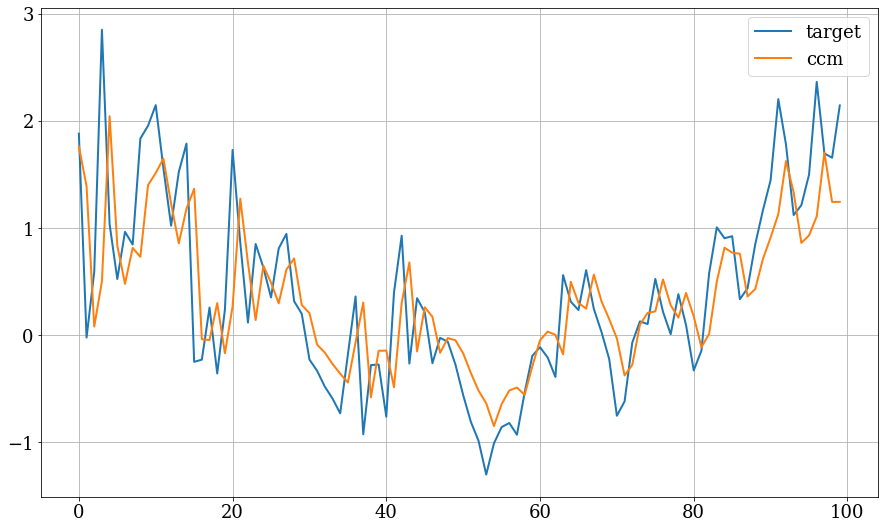

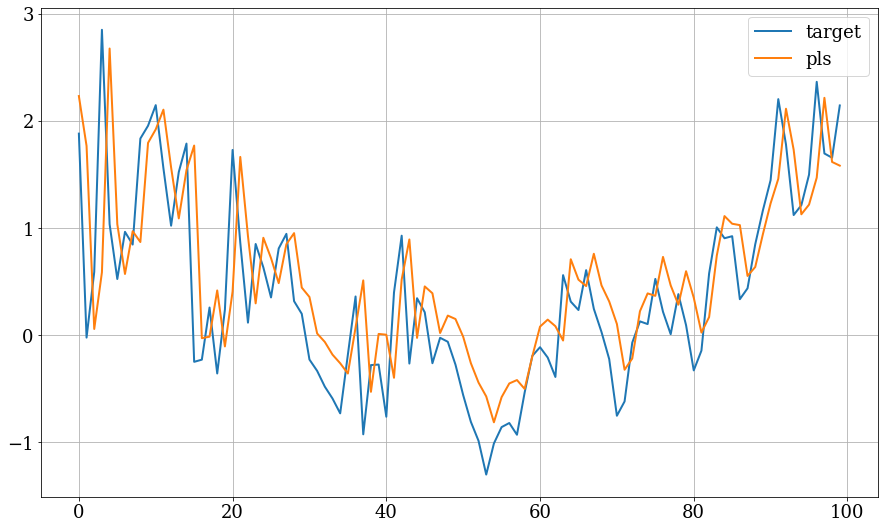

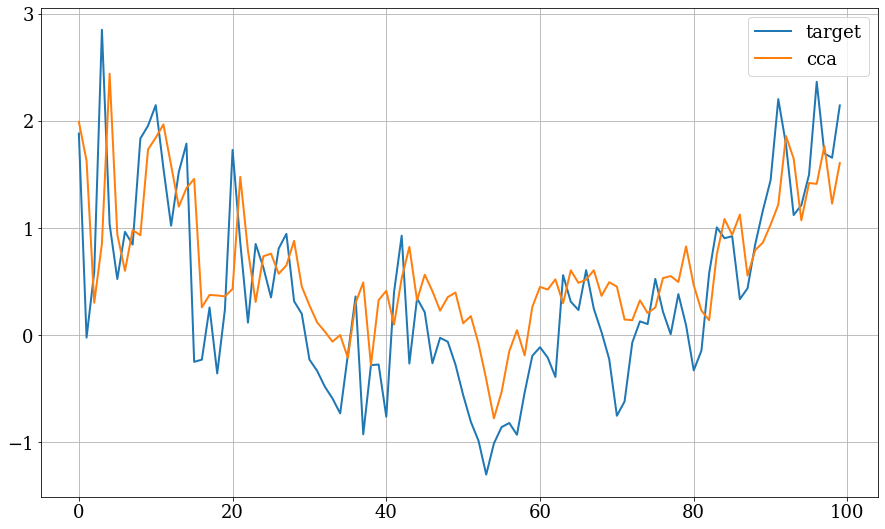

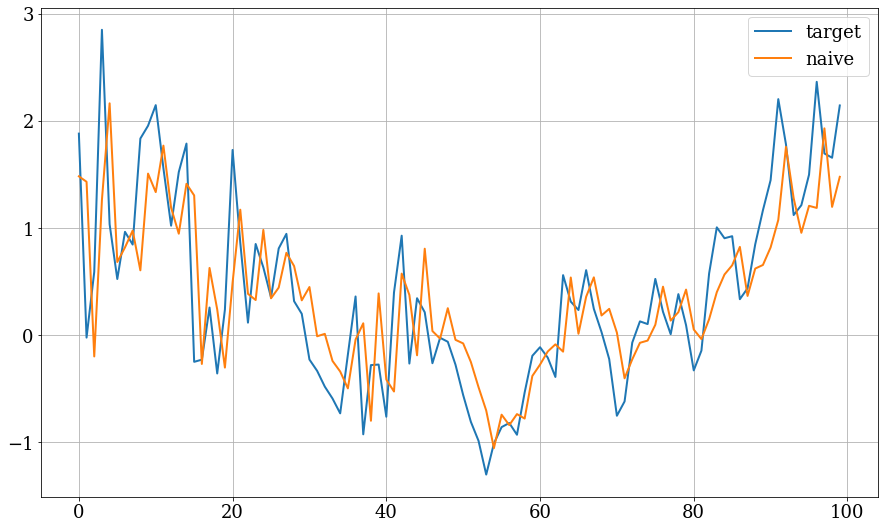

In [45]:
for col in chaotic_preds.columns[1:]:
    plt.figure(figsize=(15, 9))
    plt.plot(chaotic_preds['target'].values, label="target")
    plt.plot(chaotic_preds[col].values, label=col)

    plt.grid(True)
    plt.legend()
    plt.show()

In [64]:
cyclic_preds = collect_pred_from_diff_methods('chaotic_3', 'gyr_x')
cyclic_values = cyclic_preds.values

for i in range(cyclic_preds.shape[1]):
    print(f"{cyclic_preds.columns[i]}:", np.mean(np.square(cyclic_values[:, i] - cyclic_values[:, 0])))

target: 0.0
ccm: 0.11262035649999996
pls: 0.10707258850000001
cca: 0.36719724760000005
naive: 0.0972449314


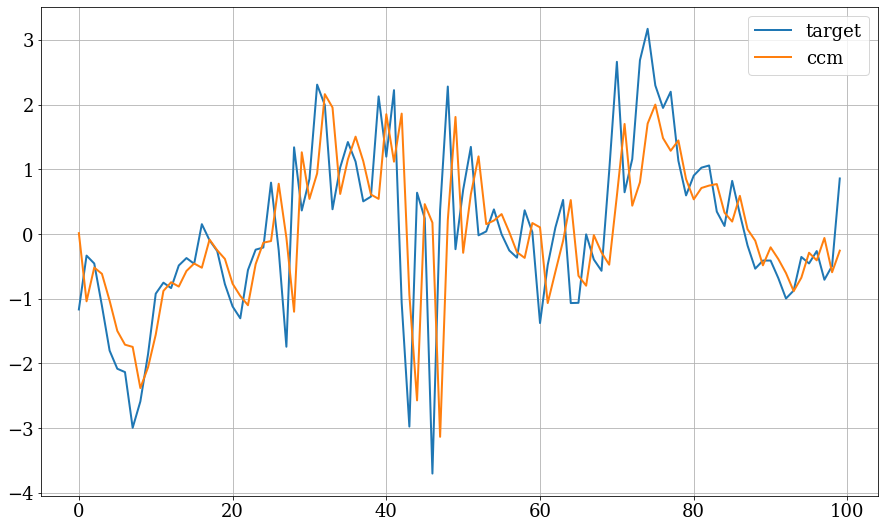

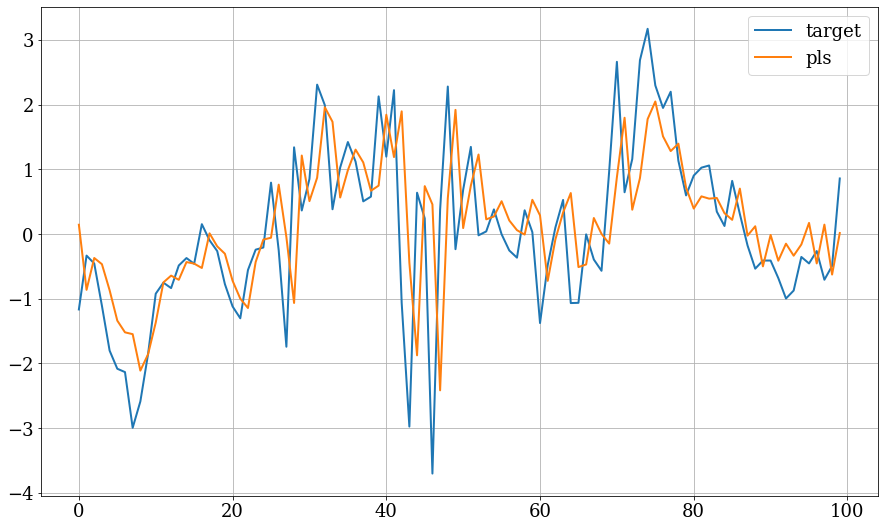

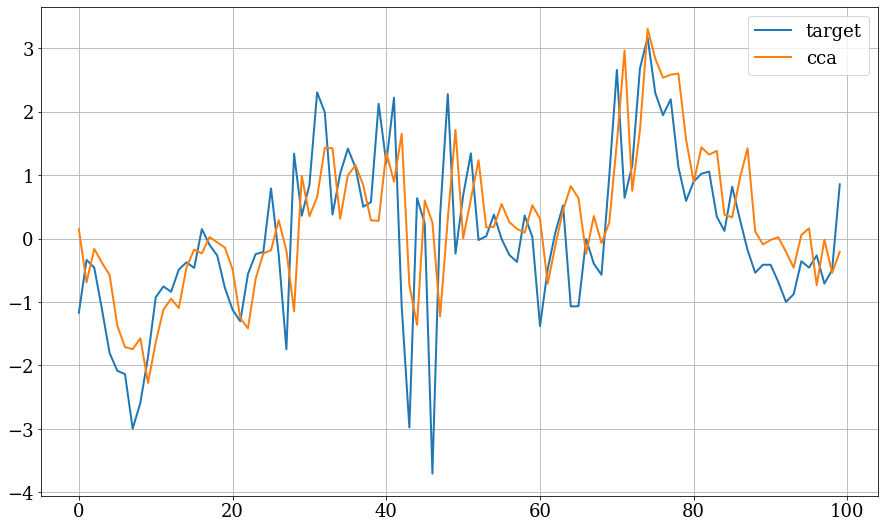

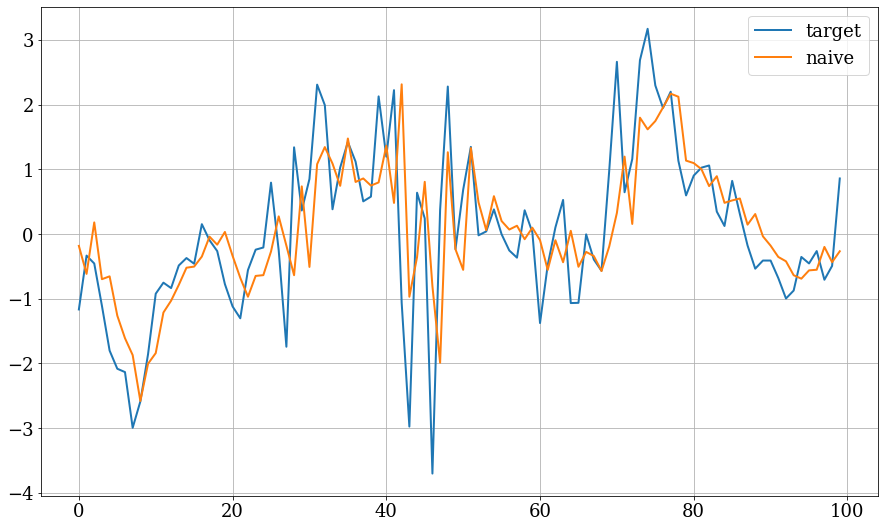

In [59]:
for col in cyclic_preds.columns[1:]:
    plt.figure(figsize=(15, 9))
    plt.plot(cyclic_preds['target'].values, label="target")
    plt.plot(cyclic_preds[col].values, label=col)

    plt.grid(True)
    plt.legend()
    plt.show()